In [ ]:
; Query the linked data in our triplestore
; to plot some info-graphics.

In [1]:
; Dependencies

(require '[clojupyter.misc.helper :as helper])
(require '[clojupyter.display :as display])

(helper/add-dependencies '[org.clojure/data.csv "1.0.0"])

(require '[clojure.java.io :as io])
(require '[clojure.pprint :as pp])
(require '[clojure.data.csv :as csv])

nil

In [2]:
; Read the data files

(defn to-maps [csv-data]
  (map zipmap
       (->> (first csv-data)
            (map keyword)
            repeat)
        (rest csv-data)))

(def waste-data
    (with-open [reader (io/reader "sepa-waste-data.csv")]
        (doall
            (to-maps (csv/read-csv reader)))))

(pp/print-table [:council :year :type :process :tonnage] (repeatedly 5 #(rand-nth waste-data)))


|          :council | :year |                                                                                 :type |                 :process | :tonnage |
|-------------------+-------+---------------------------------------------------------------------------------------+--------------------------+----------|
|      Renfrewshire |  2015 |                                                                        Plastic wastes |                Generated |        0 |
| South Lanarkshire |  2013 |                                                            Paper and cardboard wastes |                Generated |   973.04 |
| City of Edinburgh |  2017 |                                                                        Plastic wastes |               Landfilled |          |
|           Falkirk |  2018 | Discarded equipment (excluding discarded vehicles, batteries and accumulators wastes) |       Prepared for reuse |          |
| North Lanarkshire |  2018 |                                  

nil

In [3]:
(def population-data
    (with-open [reader (io/reader "nrs-population-data.csv")]
        (doall
            (to-maps (csv/read-csv reader)))))

(pp/print-table [:council :year :population] (repeatedly 5 #(rand-nth population-data)))


|          :council | :year | :population |
|-------------------+-------+-------------|
|        Midlothian |  2011 |       83450 |
|     Aberdeenshire |  2016 |      262190 |
|     Aberdeen City |  2015 |      230350 |
| South Lanarkshire |  2012 |      314330 |
|          Stirling |  2012 |       91010 |


nil

In [4]:
; The waste generated per council in 2018

(def waste-generated-2018
    (->> waste-data
        (filter #(= "2018" (:year %)))
        (filter #(= "Generated" (:process %)))
        (filter #(= "Subtotal" (:type %)))))

(pp/print-table [:council :year :type :process :tonnage] (take 5 waste-generated-2018))


|          :council | :year |    :type |  :process |  :tonnage |
|-------------------+-------+----------+-----------+-----------|
|     Aberdeen City |  2018 | Subtotal | Generated |  85539.75 |
|     Aberdeenshire |  2018 | Subtotal | Generated | 120518.79 |
|             Angus |  2018 | Subtotal | Generated |  54619.26 |
|   Argyll and Bute |  2018 | Subtotal | Generated |  47972.14 |
| City of Edinburgh |  2018 | Subtotal | Generated | 193341.11 |


nil

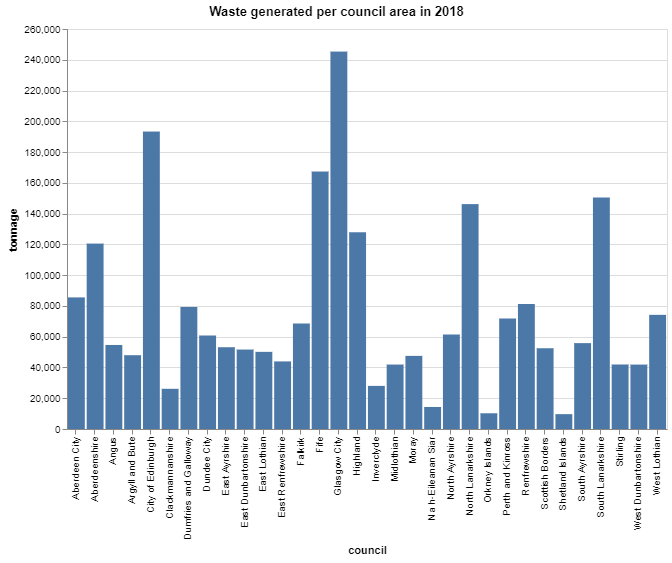

In [5]:
; Bar chart 

(defn bar-chart [title data]
  {:title title
   :width 600
   :height 400       
   :data {:values data}
   :mark "bar"
   :encoding {
              :x {:field "council"
                  :type "nominal"}
              :y {:field "tonnage"
                  :type "quantitative"}}})

(display/render-mime 
    :application/vnd.vegalite.v2+json 
    (bar-chart "Waste generated per council area in 2018" waste-generated-2018))

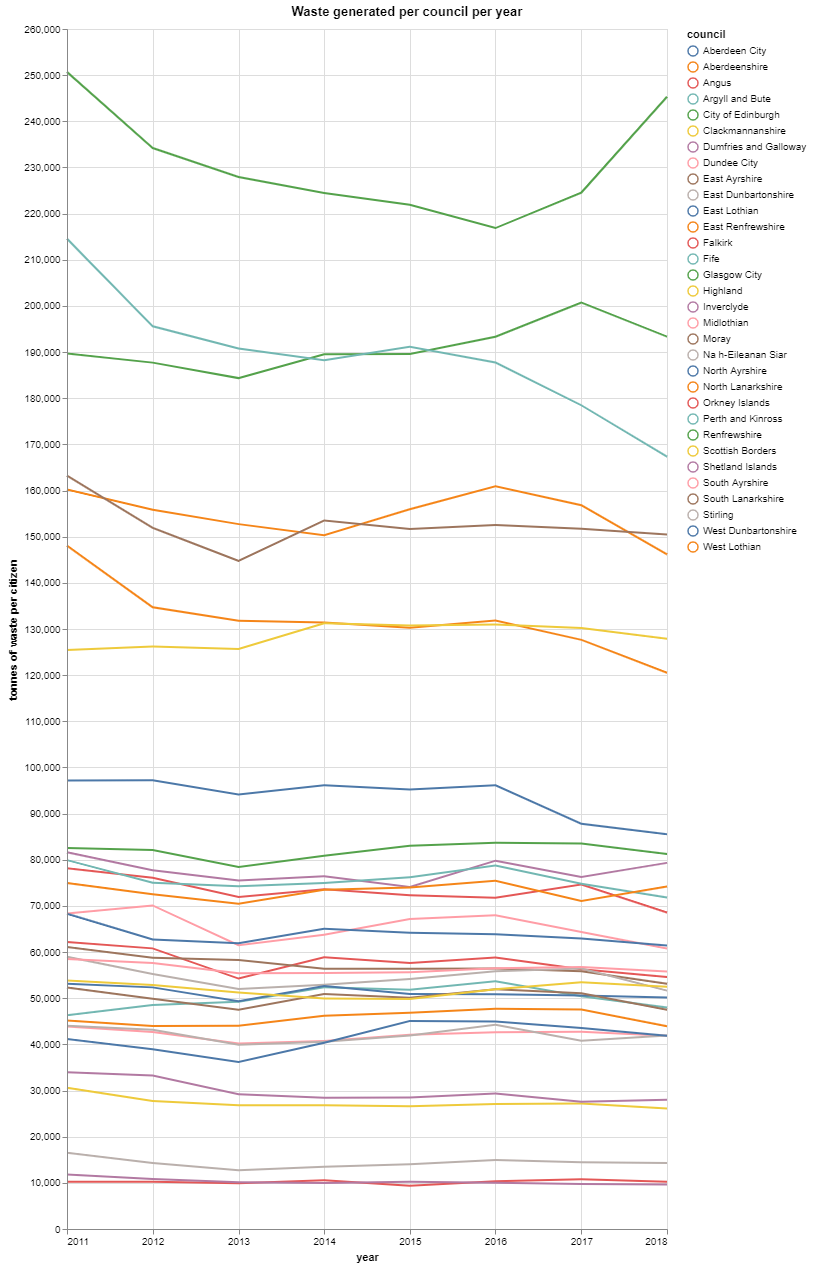

In [6]:
; The waste generated per council per year

(def waste-generated-all-years
    (->> waste-data
        (filter #(= "Generated" (:process %)))
        (filter #(= "Subtotal" (:type %)))))

(defn line-graph [title data]
  (let [year-count (count (group-by :year data))]
    {:title title
     :width 600
     :height 1200       
     :data {:values data}
     :mark "line"
     :layer [
             {
              :encoding {
                         :x {:field "year" :type "temporal" :timeUnit "year" :axis {:tickCount year-count :title "year"}}
                         :y {:field "tonnage" :type "quantitative" :scale {:zero false} :axis {:title "tonnage"}}
                         :color {:field "council" :type "nominal"}}
              :layer [
                      {:mark "line"}
                      {
                       :selection {
                                   :label {
                                           :type "single"
                                           :nearest true
                                           :on "mouseover"
                                           :encodings ["x"]
                                           :empty "none"
                                           }
                                   }
                       :mark "point"
                       :encoding {
                                  :opacity {
                                            :condition {:selection "label" :value 1}
                                            :value 0
                                            }
                                  }
                       }
                      ]
              }
             {
      :transform [{:filter {:selection "label"}}],
      :layer [
        {
          :mark {:type "rule" :color "gray"},
          :encoding {
            :x {:type "temporal"  :field "year"}
          }
        },
        {
          :encoding {
            :text {:type "nominal", :field "council"},
            :x {:type "temporal", :field "year"},
            :y {:type "quantitative", :field "tonnage"}
          },
          :layer [
            {
              :mark {
                :type "text",
                :stroke "white",
                :strokeWidth 2,
                :align "left",
                :dx 5,
                :dy -5
              }
            },
            {
              :mark {:type "text", :align "left", :dx 5, :dy -5},
              :encoding {
                :color {:type "nominal", :field "council"}
              }
            }
          ]
        }
      ]
    }
             
             ]
     }))

(display/render-mime 
    :application/vnd.vegalite.v2+json 
    (line-graph "Waste generated per council per year" waste-generated-all-years))

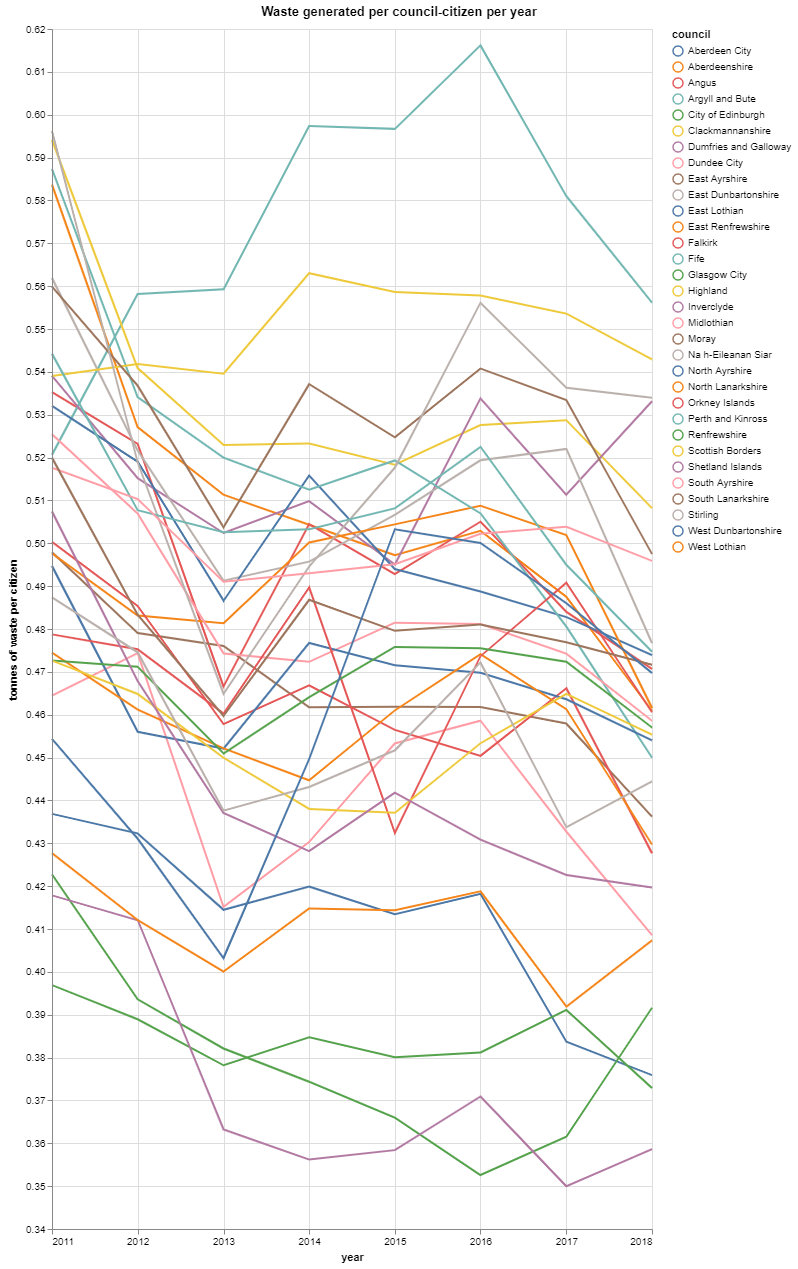

In [7]:
; The waste generated per council-citizen per year - i.e. calculate tonnage per person

(defn population [council year]
    (->> population-data
         (filter #(= council (:council %)))
         (filter #(= year (:year %)))
         first
         :population))

(def waste-generated-per-citizen-all-years
    (map #(assoc % :tonnage (/ (Double/parseDouble (:tonnage %)) (Integer/parseInt (population (:council %) (:year %)))))
         waste-generated-all-years))

(display/render-mime 
    :application/vnd.vegalite.v2+json 
    (line-graph "Waste generated per council-citizen per year"  waste-generated-per-citizen-all-years))

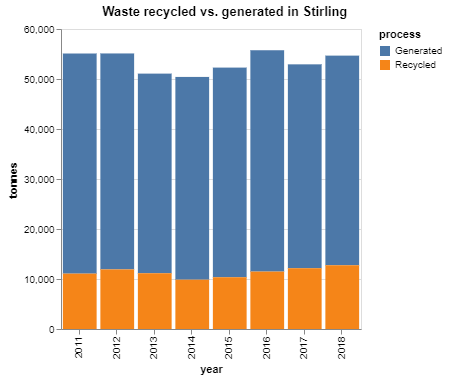

In [8]:
; Waste generated vs recycled in Stirling

(def waste-stir-generated
    (->> waste-data
        (filter #(= "Stirling" (:council %)))
        (filter #(= "Generated" (:process %)))
        (filter #(= "Subtotal" (:type %)))))

(def waste-stir-recycled
    (->> waste-data
        (filter #(= "Stirling" (:council %)))
        (filter #(= "Recycled" (:process %)))
        (filter #(= "Subtotal" (:type %)))))

(def waste-stir-comparison (concat waste-stir-generated waste-stir-recycled))

(defn stacked-bar-chart [title data]
    (let [year-count (count (group-by :year data))]
  {:title title
   :width 300
   :height 300       
   :data {:values data}
   :mark {:type "bar" :cornerRadiusTopLeft 3 :cornerRadiusTopRight 3}
   :encoding {
            :x {:field "year" :type "nominal" :title "year"}
            :y {:field "tonnage" :type "quantitative" :scale {:zero false} :axis {:title "tonnes"}}
            :color {:field "process" :type "nominal"}}}))

(display/render-mime 
    :application/vnd.vegalite.v2+json 
    (stacked-bar-chart "Waste recycled vs. generated in Stirling" waste-stir-comparison))